# CHAPTER VII

# Filtering Data and Images
&copy; Harishankar Manikantan, Chemical Engineering, UC Davis 

**[(7.1) Convolutions](#convolutions)**
*  [Moving averages as low-pass filters](#moving) <br>
*  [Matrix convolutions](#matrixconv) <br>

**[(7.2) Image Processing](#images)**
*  [Image matrices and color schemes](#color) <br>
*  [Image filters: box blur and Gaussian blur](#blur) <br>
*  [Edge detection](#edge) <br>

**[Practice problems](#exer)**



<a id='convolutions'></a>



## (7.1) Convolutions

In mathematics, a convolution is an operation where the shape of a function is modified by operating it in a specific manner by another function. Convolutions appear in statistical operations (e.g. moving averages), manipulating images (e.g. blurring, sharpening, edge detection), signal processing (e.g. band-pass filters), electronic music (e.g. reverb effect), and more. Much of convolution is fairly straightforward numerical linear algebra, and this tutorial will cover some of the basic concepts.


<a id='moving'></a>



### Moving averages as low-pass filters

Moving averages are common ways to extract trends from fluctuating data. For example, stock market charts often use moving averages to highlight trends across weeks or months by 'filtering' out the daily or even hourly fluctuations that often arise in the markets. The basic idea is to replace a data point with a local average of it's neighbors. For example, the file `dji.csv` contains the Dow Jones Index for the entire year of 2012. Let's extract the daily closing data using `pandas` and plot it:

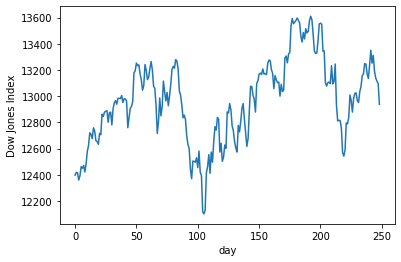

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

dji=pd.read_csv("data/dji.csv")
dji2012=dji['Close'].values

plt.plot(dji2012)
plt.xlabel('day')
plt.ylabel('Dow Jones Index')
plt.show()

As we can see, there are wild fluctuation on an almost daily basis. But we can also see that there are broader trends where the index increases for the first 50 or so days, then drops, then picks up again after about 100 days, then drops again near 200, and so on. Moving averages are a good way to extract such broader trends. A convolution that filters out the 'high frequency' fluctuations and only allows 'low frequency' trends to pass through is called a low-pass filter.

To understand convolutions in this context, consider the following operation: we first create a 3-element filter array `f3`:

In [2]:
# f= [1/3,1/3,1/3]

f3=np.array([1,1,1])/3

Then we 'pass' our data array `dji2012` through this filter and locally convolute the data. What this means is we perform an element-by-element multiplication of every 3-element subset of `dji2012` with `filter`, add up the resulting three elements, and write the result to a new array. 

For example, the 5th, 6th, and 7th entries in `dji2012` are:

In [3]:
dji2012[4:7]

array([12392.69043 , 12462.469727, 12449.450195])

Performing the convolution with the filter `f` for this subset at the 6th location then means applyting it to the 6th element and its neighbors to the left and right

In [4]:
f3[0]*dji2012[4]+f3[1]*dji2012[1]+f3[2]*dji2012[2]

12408.936848999998

For 1D vectors, this is equivalent to the dot product. Since our vector `f` had equal entries ($1/3$ each) and summed to $1$, this operation actually gives the average of the 3-element subset of `dji2012`. 'Passing' the data set through a filter is then the operation of doing the same for every 3-element subset. A loop does this trick:

In [5]:
# make a copy of data set
f3_dji=dji2012.copy()
n=len(dji2012)

for i in range(1,n-1): # avoid end data points (... justify why)
    f3_dji[i]=f3[0]*dji2012[i-1]+f3[1]*dji2012[i]+f3[2]*dji2012[i+1] 


Let's plot the original data along with our 3-day moving average now:

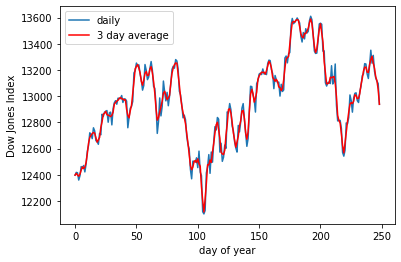

In [6]:
plt.plot(dji2012,label='daily')
plt.plot(f3_dji,'r-',label='3 day average')
plt.xlabel('day of year')
plt.ylabel('Dow Jones Index')
plt.legend()
plt.show()

We can see that some of the sharp fluctuations have been 'smoothed' out by the averaging. Since the average 'moves' to local neighbors as we move along the data set, this is called a moving average. In signal processing, such a _low-pass filter_ is useful in getting rid of noise or unwanted high-frequency disturbances. Most audio systems employ more sophisticated versions of such filtering techniques. 

We can get an even _lower_ pass or a smoother moving average by filtering across more days. The following code implements a 15-day filter and plots it:

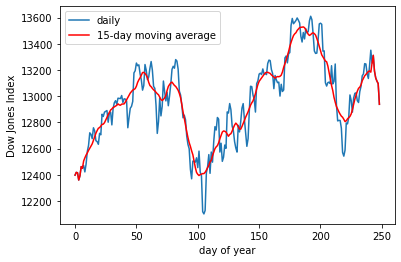

In [7]:
f15=np.ones(15)/15
f15_dji=dji2012.copy()
n=len(dji2012)

for i in range(7,n-7): # avoid end data ... think how to calculate this
    f15_dji[i]=0.
    for j in range(-7,8):
        # f index must go from 0 to 15
        # dji2012 index must go from i-7 to i+7
        f15_dji[i]+=f15[j+7]*dji2012[i+j]

plt.plot(dji2012,label='daily')
plt.plot(f15_dji,'r',label='15-day moving average')
plt.xlabel('day of year')
plt.ylabel('Dow Jones Index')
plt.legend()
plt.show()

We get more and more 'smoothed' moving averages with a larger window of smoothing. There will always be unsmoothed end points because there are not enough points to the left of the first few points and not enough data to the right of the last few points. These are called 'end effects', and we could construct `if` conditions and write modified filters just for the ennd points to make it more accurate.  We will see more about end effects when we start talking about finite differences in coming weeks. 

However, python has an inbuilt convolution operator `scipy.ndimage.convolve(data,filter)` that works exactly like the above code (and accounts for the 'end effect' automatically). As we will see later, convolutions are common in image processing so this python function is in the image processing module `scipy.ndimage`, which we must first import. The following code demonstrates a convolution to perform a moving average across _m_-days automatically:

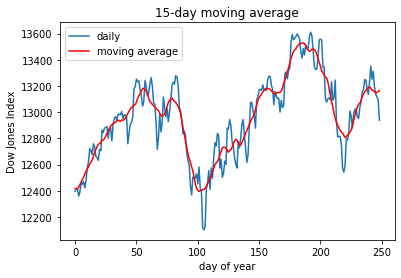

In [5]:
import scipy.ndimage as sim

# moving average days
m=15
f=np.ones(m)/m
f_dji=sim.convolve(dji2012,f)

plt.plot(dji2012,label='daily')
plt.plot(f_dji,'r',label='moving average')
plt.xlabel('day of year')
plt.ylabel('Dow Jones Index')
plt.title('%d-day moving average'%m)
plt.legend()
plt.show()

This looks identical to our own looped convolution code above, except near the end points where `sim.comvolve` automatically changes the filter to accommodate end effects. Try changing to 25 or 50 day averages to get more smooth trends that ignore daily or weekly fluctuations. 



Another application of moving averages or low-pass filters is acoustics and signal processing. For example, the following time signal is a combination of sine waves of several frequencies:

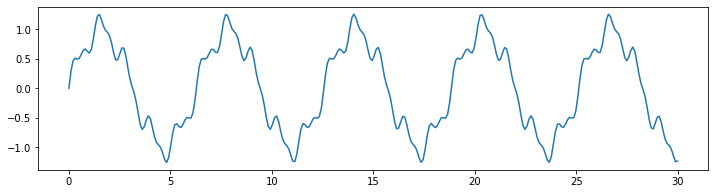

In [5]:
t=np.linspace(0,30,300)
s=np.sin(t)+0.2*np.sin(5*t)+0.1*np.sin(10*t)

plt.figure(figsize=(12,3))
plt.plot(t,s)
plt.show()

In music and speech, the lower frequencies (e.g. $\sin(t)$ above) represent deep bass-like sounds and the higher frequencies (e.g. $\sin(10t)$ above) represent higher-pitched or 'shrill' sounds. Depending on your signal needs or music tastes or speaker settings, you might often want to 'filter' out some of a higher frequencies. A rough way to do this is to apply our simple low-pass filter which performs a convolution corresponding to a moving average:

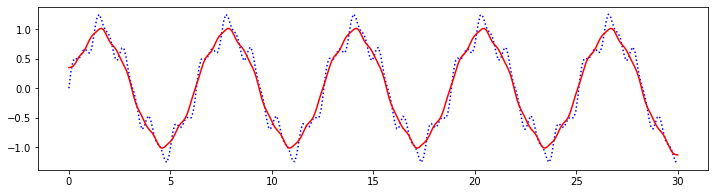

In [12]:
m=10
f=np.ones(m)/m
sf=sim.convolve(s,f)

plt.figure(figsize=(12,3))
plt.plot(t,s,'b:')
plt.plot(t,sf,'r')
plt.show()

The sharper features of the high-frequency component are filtered out! Try 'tuning' the filter length `m` to vary this: a broader filter smoothes out more of the fluctuations. Try $m=20$ or $50$...
 
This is only a coarse way to process signals: more careful analysis can be done using Fourier transforms to pick out specific frequencies, but that is beyond the scope of this course.

<a id='gradientfilter'></a>

Finally, there are all sorts of other filters designed to extract different features in a data set or signal. For example, the **gradient filter** $[-1,0,1]$ enhances local changes. By replacing each element by the difference between its neighbors, the gradient filter picks up on rapid changes in the signal: this is a valuable trick in image processing as we will see below. 

Try applying the gradient filter to the mixed-sine signal above. Then try applying it to a simple sine wave. What does the resulting convolution of a simple sine wave look like? Remember that the gradient filter is desgined to extract and emphasize differences. Think about what this means in a calculus sense (a big hint is the name of the filter!).

<a id='matrixconv'></a>



### Convolving matrices

The same idea as above applies to 2D matrices. Here, instead of passing a 1D array through a 1D filter, we would sequentially place a 2D filter over every subset of a matrix of the same size and perform the convolution. For example, recall the temperature dataset from tutorial 2 that was quite noisy. The following code is copied from tutorial 2:

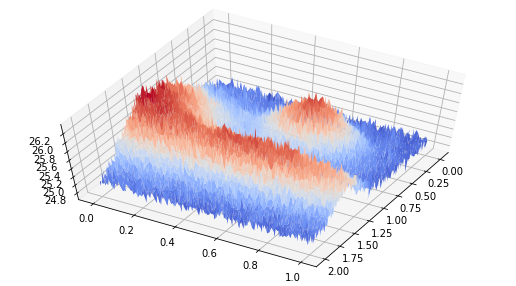

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# load, create x and y, xgrid and ygrid
temp_data=np.loadtxt("data/temperature.csv", delimiter=",")
ny,nx=temp_data.shape
xx=np.linspace(0,2,nx)
yy=np.linspace(0,1,ny)
xgrid, ygrid = np.meshgrid(xx,yy)

# surface plot
mynewfig = plt.figure(figsize=(9,5))
mynewaxis = mynewfig.gca(projection='3d')
mynewaxis.plot_surface(xgrid,ygrid,temp_data,cmap='coolwarm')

# pick viewing angle
mynewaxis.view_init(60,30)
plt.show()



Clearly there are a lot of sharp 'peaks' in this data set. Convolving this data set with the low-pass of moving average *matrix filter*:

$$F=\frac{1}{9}~\begin{bmatrix} 1 & 1 & 1 \\1 & 1 & 1 \\1 & 1 & 1  \end{bmatrix}$$

results in replacing each point with the mean (itself and all its immediate neighbors multiplied by $1$ and the total divided by $9$). We can write a nested loop-within-a-loop to go across each element in `temp_data` and sequentially find the filtered value, or we could use `sim.convolve(temp_data,F)` to do the same operation more efficiently exactly like with 1D arrays.

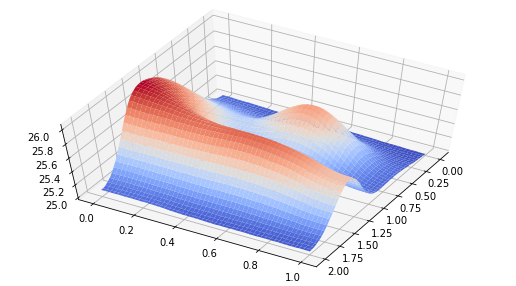

In [14]:
m=30
F=np.ones((m,m))/m**2
temp_filtered=sim.convolve(temp_data,F)

# surface plot
mynewfig = plt.figure(figsize=(9,5))
mynewaxis = mynewfig.gca(projection='3d')
mynewaxis.plot_surface(xgrid,ygrid,temp_filtered,cmap='coolwarm')

# pick viewing angle
mynewaxis.view_init(60,30)
plt.show()

Looks like some of the noisy (high frequency) data is smoothed out by our low-pass filter. We can create broader filters for smoother convolutions. See what happens with a $5 \times 5$ moving average with $m=5$. Then try $m=10$ or $20$ ...! Note that this convolution matrix is constructed such that the sum of its elements is $1$, so that it represents an equally-weighted moving average.

<a id='images'></a>



## (7.2) Image processing

We can now apply convolutions and filters to actual images rather than data sets. But first, we need to know a couple of things about importing and color schemes of actual images.

<a id='color'></a>



### Image matrices and color schemes

Recall the `imshow` command from tutorial 2. Given a 2D array, this command would plot a pseudocolor representation of the data to look like an image. The exact opposite is done by the `imread` command. It reads an image file (jpg, png, etc. **from the same folder as your code**) and converts it to a range of numbers. For example, the file `FluorescentCells.jpg` sourced from [here](https://commons.wikimedia.org/wiki/File:FluorescentCells.jpg) can be extracted and displayed as:

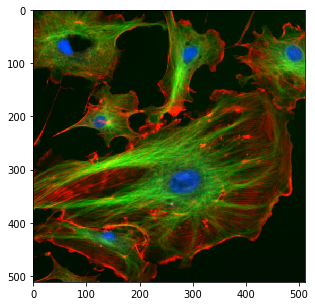

In [3]:
figarray=plt.imread('images/FluorescentCells.jpg')
plt.figure(figsize=(5,5))
plt.imshow(figarray)
plt.show()

You can check the shape of the array variable `figdata`:

In [14]:
figarray.shape

(512, 512, 3)

So it's a 3D matrix! And let's see the maximum and minimum entries:

In [15]:
print('max:', figarray.max())
print('min:', figarray.min())

max: 255
min: 0


In fact, this represents the standard 8-bit (meaning $2^8=256$ values) RGB (for red-blue-green) color scheme of jpg files. The dimensions $512 \times 512$ represents the number of pixels as shown in the plot axes above. And the three values in the third dimension represent red, green, and blue intensities between $0$ and $255$, respectively at each pixel location. Higher the intensity number, brighter is red, blue, or green. Black is when all three are zero, and white is when all three are $255$. All other colors are mixtures of these three basic colors: for example, pure yellow is full red plus full green.

This also means that you can slice the array like any matrix to extract only the red, green, or blue parts of any image! The file above showed a fluorescent microscopy image where the nucleus was stained blue, the microtubules (the 'skeleton' of the cell) was stained green, and actin (a kind of cellular biopolymer) was stained red. If we wanted to view the microtubules only, we would simply slice `figarray[:,:,1]` which would extract all pixels corresponding to green intensity. Similarly, `figarray[:,:,0]` would extract reds and `figarray[:,:,2]` would extract blues:

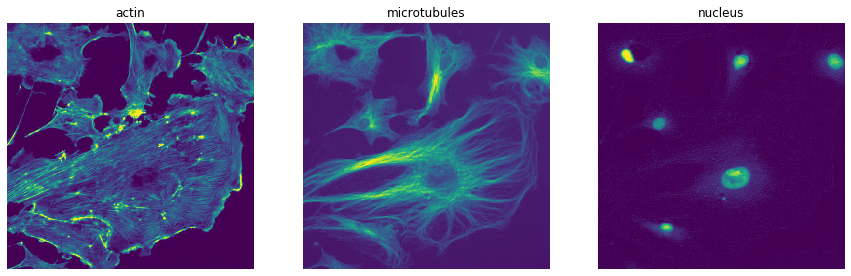

In [16]:
r=figarray[:,:,0]  # red slice
g=figarray[:,:,1]  # green slice
b=figarray[:,:,2]  # blue slice


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(r) # red slice
plt.title('actin')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(g) # green slice
plt.title('microtubules')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(b) # blue slice
plt.title('nucleus')
plt.axis('off')

plt.show()

Here, `imshow` automatically picks a colormap (`cmap`) unless we specify it. We can assign our favorite colormaps but it makes sense to see blue stained things in a blue colormap and so on. The following code extracts and assigns matching colormaps to each stain to make it more easily distinguishable:

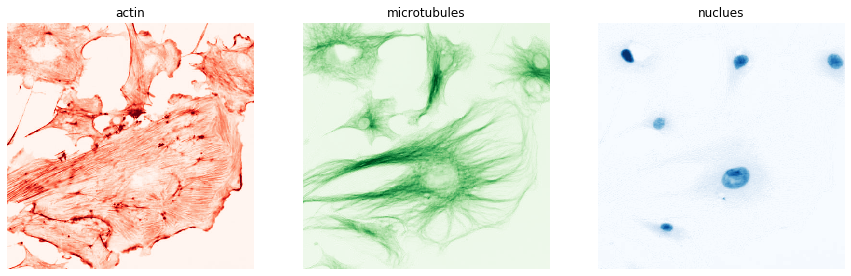

In [17]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(r,cmap='Reds')
plt.title('actin')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(g,cmap='Greens')
plt.title('microtubules')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(b,cmap='Blues')
plt.title('nuclues')
plt.axis('off')

plt.show()

We can then *threshold* colors: this means we can select to display only above or below a certain intensity of a color. For example, actin biopolymers are known to be more concentrated around cell edges to help growth and movement. We can see this in the first panel above, but let's say we want to emphasize this. An easy way to detect entries of an array that are above or below a certain value is to threshold it using a logical comparison. For example:

In [18]:
M=np.array([[1,7,4],[11,5,6],[3,9,2]])
print("original matrix: \n", M)

M1=(M>5)*M
print("thresholded: above 5 only \n", M1)

original matrix: 
 [[ 1  7  4]
 [11  5  6]
 [ 3  9  2]]
thresholded: above 5 only 
 [[ 0  7  0]
 [11  0  6]
 [ 0  9  0]]


Essentially, the operation `M>5`  creates a matrix which is `True` only if the logical condition is met and `False` otherwise. Multiplying this with `M` again extracts these true values. Try different comparisons: for example, `(M==2)*M` sets every entry that is not equal to two to zero, whereas `(M%2==0)*M` retains every even entry and sets odd entries to zero. Try both.

We can implement this idea to get threshold a color slice with a brighness value. For example, the following code thresholds the actin slice (red data) with two different thresholds on the red slice.

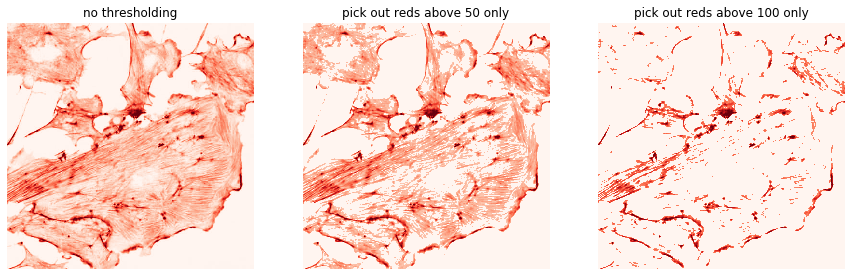

In [19]:
r1=(r>50)*r   # only r values greater than 50, rest turns to 0
r2=(r>100)*r  # only r values greater than 100, rest turns to 0

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(r,cmap='Reds')
plt.title('no thresholding')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(r1,cmap='Reds')
plt.title('pick out reds above 50 only')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(r2,cmap='Reds')
plt.title('pick out reds above 100 only')
plt.axis('off')

plt.show()

PNG files often have a fourth slice in addition to RGB values, and this corresponds to an alpha setting (which represents transparency).

What if we wanted to convert the color image to grayscale: this might be useful in some kinds of image processing as we will see later where we need a simple 2D matrix without the third dimension with different color intensities. There are many ways to do this: for example, we could define grayscale intensity as one-third red + one-third blue + one-third green. Another common formula used by image processors picks up 29.9% red, 58.7% green, and 11.4% blue. This can be achieved by

In [20]:
figBW=figarray[:,:,0]*0.299 + figarray[:,:,1]*0.587 + figarray[:,:,2]*0.114

Note that `figBW` is a simple 2D array with no third dimension. We have 'collapsed' the colors into a single grayscale intensity between 0 and 255:

In [21]:
figBW.shape

(512, 512)

And we can visualize this using `imshow` like before. Again, instead of the default colormap, it makes sense to plot grayscale using a black-and-white colormap. A good choice is `cmap='binary'` (going from black at the lowest number to white at the highest) or `cmap='gray'` (which is reversed):

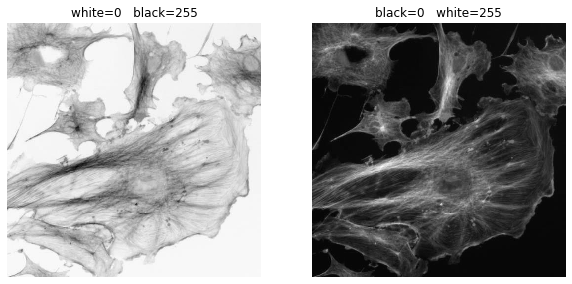

In [22]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(figBW,cmap='binary')
plt.title('white=0   black=255')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(figBW,cmap='gray')
plt.title('black=0   white=255')
plt.axis('off')

plt.show()

<a id='blur'></a>



### Image filters: box blur and Gaussian blur

We can apply the same logic of convolutions matrices to locally avarage out or extract gradients in images as well. The convolution matrices or filters are called 'kernels' in the image processing context. 

For example, let's see what our simple moving-average filter does to an image. First, extract the file `bacteria.jpg` and convert it to grayscale:

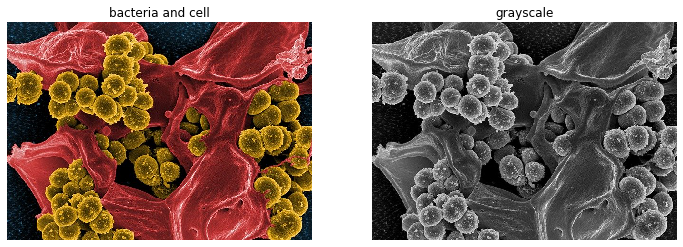

In [8]:
bact=plt.imread('images/bacteria.jpg')
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(bact)
plt.title('bacteria and cell')
plt.axis('off')

plt.subplot(1,2,2)
bactBW=bact[:,:,0]*0.299 + bact[:,:,1]*0.587 + bact[:,:,2]*0.114
plt.imshow(bactBW,cmap='gray')
plt.title('grayscale')
plt.axis('off')

plt.show()

Now, let's convolve a $3 \times 3$ moving average filter and a $10 \times 10$ moving average filter to see what happens:

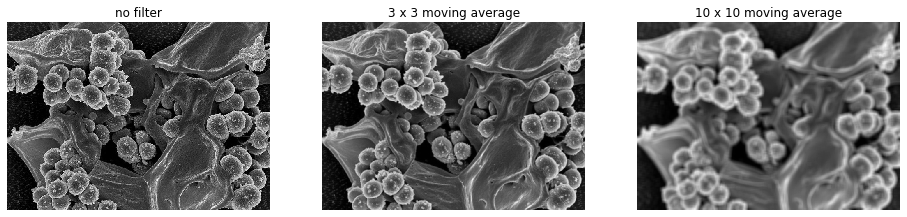

In [28]:
f3=np.ones((3,3))/9
f10=np.ones((10,10))/100

bact_filter3 = sim.convolve(bactBW,f3)
bact_filter10 = sim.convolve(bactBW,f10)

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(bactBW,cmap='gray')
plt.axis('off')
plt.title('no filter')

plt.subplot(1,3,2)
plt.imshow(bact_filter3,cmap='gray')
plt.axis('off')
plt.title('3 x 3 moving average')

plt.subplot(1,3,3)
plt.imshow(bact_filter10,cmap='gray')
plt.axis('off')
plt.title('10 x 10 moving average')

plt.show()

As we can see, the moving average filter has a 'blurring' effect. Blurring is useful in many cases to get rid of unnecessary 'grainineess' or artefacts associated with signal or microscopy noise by averaging these out. In fact, these convolutions are called **box blurs** in the field of image processing. While the $3 \times 3$ gets rid of the noise and makes for a smooth image, the $10 \times 10$ filter goes too far and 'unfocuses' details. Try other box blur filter sizes to see how they look for this particular image.

We can do the same tricks with colored imaged as well. We could device 3D convolution matrices or perform convolutions for each color slice. Blurring colored images is left an an optional exercise if you feel adventurous.

Often, blurring is done with a more sophisticated convolution matrix called the **Gaussian blur**, especially in photography, graphics and computer vision. While the box filter assigns equal weightage to each pixel (a $3 \times 3$ filter had a 'weight' of $1/9$ each so the weight added up to $1$, etc.), the Gaussian filter assigns a weight that decreases as you go farther away. For instance, an approximate form of the $3 \times 3$ Gaussian blur convolution matrix is 

In [25]:
gaussfilter=np.array([[1,2,1],[2,4,2],[1,2,1]])/16

A more detailed application of a Gaussian blur is in practice problem x

<a id='edge'></a>



### Edge detection

Another common image processing convolution stems from the [gradient filter](#gradientfilter) we saw earlier. In 1D, the filter $[-1,0,1]$ amplifies difference before neighbors and therefore emphasizes changes. A 2D extension of this is called the **gradient kernel**. There are many versions of this, and a common one is the _Sobel operator_ which is defined separately along the x- and y-axes:

$$ G_x = \begin{bmatrix} -1 & 0 & 1 \\-2 & 0 & 2 \\-1 & 0 & 1  \end{bmatrix}, \qquad G_y = \begin{bmatrix} -1 & -2 & -1 \\0 & 0 & 0 \\1 & 2 & 1  \end{bmatrix} $$

These filters emhasize gradients or changes in the horizontal and vertical directions, respectively (with an added boost to the current row or column, hence the 2 instead of 1 in the middle row or column).

These filters are excellent at detecting features that change in the horizontal or vertical direction. And the root-mean-square of the two convolutions can detect overall changes and therefore act as an **edge detector**. For example, we can use the Sobel operators to pick up horizontal and vertical features of the Golden Gate bridge, and combine the two to get an outline image. It might be necessary to change the minimum and maximum of the colorbar ranges for more contrast in visualization (see tutorial 2 for colorbar control). This can be done by careful thresholding as well.

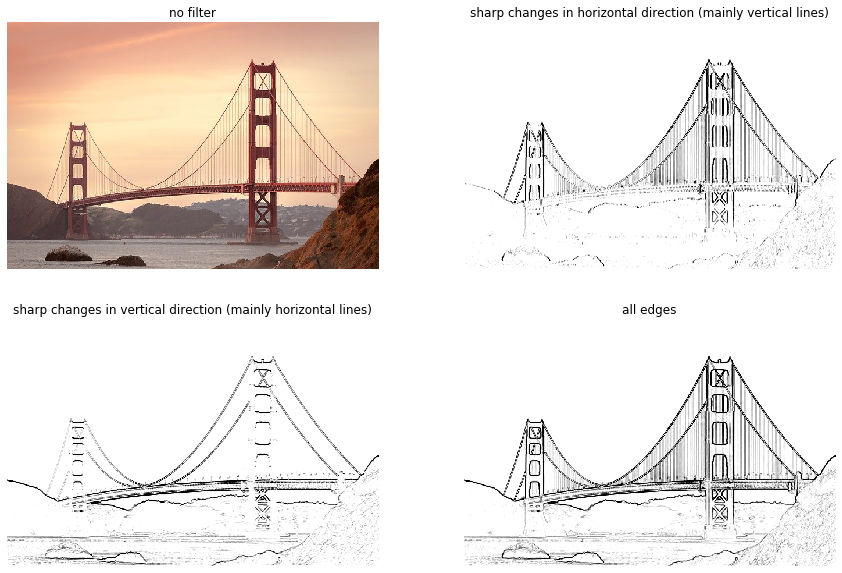

In [6]:
#read image, convert to BW
gg=plt.imread('images/gg.jpg')

ggBW=gg[:,:,0]*0.299 + gg[:,:,1]*0.587 + gg[:,:,2]*0.114

# horizontal and vertical Sobel operators
Gx = [[-1,0,1], [-2,0,2], [-1,0,1]]
Gy = [[-1,-2,-1], [0,0,0], [1,2,1]]

gg_hori = sim.convolve(ggBW,Gx)
gg_vert = sim.convolve(ggBW,Gy)
gg_edges = np.sqrt(gg_vert**2+gg_hori**2)


# plot

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(gg,cmap='binary')
plt.axis('off')
plt.title('no filter')

plt.subplot(2,2,2)
plt.imshow(abs(gg_hori),cmap='binary',vmin=0.05*gg_hori.max(),vmax=0.5*gg_hori.max())
plt.axis('off')
plt.title('sharp changes in horizontal direction (mainly vertical lines)')

plt.subplot(2,2,3)
plt.imshow(abs(gg_vert),cmap='binary',vmin=0.05*gg_vert.max(),vmax=0.5*gg_vert.max())
plt.axis('off')
plt.title('sharp changes in vertical direction (mainly horizontal lines)')

plt.subplot(2,2,4)
plt.imshow(gg_edges,cmap='binary',vmin=0.05*gg_edges.max(),vmax=0.5*gg_edges.max())
plt.axis('off')
plt.title('all edges')

plt.show()

Edge detection can be extremely useful in automating experiments for cell counts, materials characterization, MEMS design and fabrication, among other examples. 

Python has many more modules for advanced image manipulation and processing. The [scikit image library](https://scikit-image.org/docs/stable/auto_examples/) is a fantastic one-stop resource for a lot of specialized tools that are beyond the scope of this course, but which you can easily learn using the examples in the link if you are interested.



<a id='exer'></a>



## Practice Problems

(1) The fluorescence image of hela cells in the supplied file `hela.jpg` shows microtubules in green, DNA in cyan, and Golgi apparatus in orange. Extract the RGB slices and show them separately. Threshold the Golgi locations to show only those pixels which are at least 50% red (equivalent to red intensity 128 or higher).

(2) Import the provided close-up figure of a leaf in `leaf.jpg`. This image is 640x480 pixels. Extract a subset of this image corresponding to the central 240x160 pixels. Convert this subset to grayscale. Perform an edge detection to emphasize the vasculature (or 'veins') of the leaf. 

(3a) Import the image file `yeast.jpg` (image license at [this source](https://commons.wikimedia.org/wiki/File:Yeast_membrane_proteins.jpg)). These are yeast cells tagged with green and red fluorescent proteins. Separate and display only the cells that are strongly tagged by red proteins. Try different threshold values to pick one that is reasonable.

(3b) Do the same with green proteins as well. Note that when both red and green are displayed, the result is yellow. So both your R and G slices will have a large number when the cell is bright yellow.

(3c) Convert `yeast.jpg` to a grayscale array and run an edge detection code on it. 

(4) Always first check for the image size using `.shape` to determine if there are 3 RGB slices and appropriately collapse them to grayscale only if necessary. For example, import the supplied file `ZnO.png` (mage licence at [this source](https://commons.wikimedia.org/wiki/File:Zinc_oxide_nanoparticles_crop.png)) showing a scanning electron microscope image of zinc oxide nanoparticles and find the edges. This is already a grayscale image so there is no third dimension to the imported array: adapt the code to account for this change. 

(5) A more accurate Gaussian blur follows the 2D Gaussian function $G(x,y)=e^{-(x^2+y^2)/r^2}$. Here, $r$ is the 'spread' of the Gaussian: a larger $r$ would blur by averaging across a wider window with weights that follow the Gaussian function. 

The objective of this problem is to create a $10\times 10$ Gaussian blur filter. First, create two 1D arrays that go from $-1$ to $1$ in 10 steps:

Then create 2D grid matrices corresponding to the 1D arrays from above:

Then, create a 2D array `G` which contains the value of the Gaussian function at each point of the grid. Leave $r$ as a variable that can be supplied. Visualize this matrix using `imshow` for $r=1$.

(6) Often, images are too noisy or grainy for simple edge detection routines to work efficiently. In such cases, we need to filter the image first using a Gaussian blur to remove some of the noise. 

First, try detecting edges of the image `detect.jpg` using the gradient filters. Adjust `vmin` and `vmax` to see if any manipulations help in extracting the edges.

Now, convolve the image with Gaussian blur from problem 5 first. Apply the edge detection gradient filters on the resulting blurred image. Now manipulate `vmin` and `vmax` to display a well-contrated image showing only the edges.